# Modeling and Evaluation
In this section, I will first train a few models with the following steps:

1. Fit features into linear regression
    - without standard scaling
    - with standard scaling
2. Fit lasso/ridge/elastic net 
    - with default parameters.
    - with tuned hyperparameters

Then, I will: 

3. Evaluate model for fine-tuning
    - remove features that are not significant
    - remove features that have multicollinearity 
4. Identify and submit a production model

In [1]:
# Import the standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import logistic regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# read in data from preprocessing stage
df = pd.read_csv('datasets/preprocessed_train_data.csv')
df_pred = pd.read_csv('datasets/preprocessed_test_data.csv')

In [3]:
df.shape

(150634, 35)

In [4]:
df_pred.shape # the test data is roughly 10% of train data

(16737, 35)

In [5]:
df.head() # resale price is already transformed to log in preprocessing stage

,flat_type,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,mid,hdb_age,year_completed,commercial,market_hawker,...,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_Multi Generation,model_New Generation,model_Premium Apartment Loft,model_Premium Maisonette,model_Special,sec_cutoff
0,0,90.0,2006,13.429848,2016,11,15,2005,0,0,...,0,0,1,0,0,0,0,0,0,255053.886435
1,1,130.0,1987,13.407542,2012,8,34,1987,0,0,...,0,0,0,0,0,0,0,0,0,103911.500629
2,2,144.0,1997,13.638773,2013,14,24,1996,0,0,...,0,0,0,0,0,0,0,0,0,33854.016862
3,0,103.0,1992,13.217674,2012,3,29,1990,1,0,...,0,0,1,0,0,0,0,0,0,98547.428522
4,0,83.0,1987,12.604849,2017,2,34,1987,0,0,...,0,0,1,0,0,0,0,0,0,64901.290400


In [6]:
df_pred.head()

,id,flat_type,floor_area_sqm,lease_commence_date,Tranc_Year,mid,hdb_age,year_completed,commercial,market_hawker,...,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_Multi Generation,model_New Generation,model_Premium Apartment Loft,model_Premium Maisonette,model_Special,sec_cutoff
0,114982,0,84.0,1987,2012,8,34,1986,1,0,...,0,0,1,0,0,0,0,0,0,34078.273019
1,95653,1,112.0,2008,2019,5,13,2002,0,0,...,0,0,0,0,0,0,0,0,0,147134.965932
2,40303,3,68.0,1980,2013,8,41,1979,0,0,...,0,0,0,0,0,1,0,0,0,74742.441795
3,109506,0,97.0,1979,2017,2,42,1976,0,0,...,0,0,0,0,0,1,0,0,0,81489.463089
4,100149,0,103.0,1985,2016,17,36,1985,0,0,...,0,0,1,0,0,0,0,0,0,48456.865525


In [7]:
# set up X and y variables:
X = df.drop(['resale_price'], axis = 'columns')
y = df['resale_price']

In [8]:
# split training and validation sets from train data:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # use 80/20 split
                                                    random_state = 42)

In [9]:
pd.set_option('display.max_columns', None)
df_pred.head()

,id,flat_type,floor_area_sqm,lease_commence_date,Tranc_Year,mid,hdb_age,year_completed,commercial,market_hawker,multistorey_carpark,total_dwelling_units,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,cutoff_point,remaining_lease_years,region_East,region_North,region_North East,region_West,model_Apartment,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_Multi Generation,model_New Generation,model_Premium Apartment Loft,model_Premium Maisonette,model_Special,sec_cutoff
0,114982,0,84.0,1987,2012,8,34,1986,1,0,0,132,877.431572,687.576779,686.660434,75.683952,426.467910,156.322353,218,64,0,1,0,0,0,0,0,1,0,0,0,0,0,0,34078.273019
1,95653,1,112.0,2008,2019,5,13,2002,0,0,0,53,534.037705,2122.346226,169.478175,88.993058,439.756851,739.371688,199,85,0,0,0,1,1,0,0,0,0,0,0,0,0,0,147134.965932
2,40303,3,68.0,1980,2013,8,41,1979,0,0,0,218,817.050453,152.287621,694.220448,86.303575,355.882207,305.071191,245,57,0,0,1,0,0,0,0,0,0,0,1,0,0,0,74742.441795
3,109506,0,97.0,1979,2017,2,42,1976,0,0,0,104,1272.737194,501.892158,1117.203587,108.459039,929.744711,433.454591,188,56,0,1,0,0,0,0,0,0,0,0,1,0,0,0,81489.463089
4,100149,0,103.0,1985,2016,17,36,1985,0,0,0,144,1070.963675,437.593564,987.976010,113.645431,309.926934,217.295361,223,62,0,0,0,1,0,0,0,1,0,0,0,0,0,0,48456.865525


In [10]:
df.head()

,flat_type,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,mid,hdb_age,year_completed,commercial,market_hawker,multistorey_carpark,total_dwelling_units,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,cutoff_point,remaining_lease_years,region_East,region_North,region_North East,region_West,model_Apartment,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_Multi Generation,model_New Generation,model_Premium Apartment Loft,model_Premium Maisonette,model_Special,sec_cutoff
0,0,90.0,2006,13.429848,2016,11,15,2005,0,0,0,142,1094.090418,154.753357,330.083069,29.427395,1138.633422,1138.633422,224,83,0,0,0,0,0,0,0,1,0,0,0,0,0,0,255053.886435
1,1,130.0,1987,13.407542,2012,8,34,1987,0,0,0,112,866.941448,640.151925,903.659703,58.207761,415.607357,447.894399,232,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103911.500629
2,2,144.0,1997,13.638773,2013,14,24,1996,0,0,0,90,1459.579948,1762.082341,1334.251197,214.747860,498.849039,180.074558,188,74,0,0,0,1,1,0,0,0,0,0,0,0,0,0,33854.016862
3,0,103.0,1992,13.217674,2012,3,29,1990,1,0,0,75,950.175199,726.215262,907.453484,43.396521,389.515528,389.515528,253,69,0,0,0,0,0,0,0,1,0,0,0,0,0,0,98547.428522
4,0,83.0,1987,12.604849,2017,2,34,1987,0,0,0,48,729.771895,1540.151439,412.343032,129.422752,401.200584,312.025435,208,64,0,1,0,0,0,0,0,1,0,0,0,0,0,0,64901.290400


## Modelling

In this section, I will be running a few models. The goal is to explore their potential as the best model to run, so I can re-identify the right features and retrain this best model
1. I will be running Linear Regression, Ridge Regression, Lasso Regression and ElasticNet Regression
2. For each of the models, I will try a base version first
    - vanilla Linear Regression vs Linear Regression with standard scaling
    - normal Ridge Regression vs Ridge Regression with tuned hyperparameters
    - normal Lasso Regression vs Lasso Regression with tuned hyperparameters
    - normal ElasticNet vs ElasticNet with tuned hyperparameters
3. For each of the models, I will be doing the evaluation on the r2 scores of the train and validation sets in train-test-split

### 0. Base model

The base model is to use the mean of the train data set to predict the resale price of a HDB. We will use this in the evaluation with the production model later.

In [11]:
# base model predictions
mean_y = np.mean(df['resale_price'])

# get the rmse of the residuals

pred_base = np.array([mean_y for i in range(len(df['resale_price']))])
residuals_base_model = y - pred_base # use the whole df
squared_residuals = residuals_base_model ** 2
mean_squared_residuals = np.mean(squared_residuals)
rmse_base_model = np.sqrt(mean_squared_residuals)

print (f'RMSE for base model is: {rmse_base_model}')

RMSE for base model is: 0.30215097516294764


### 1. Vanilla Linear Regression

In [12]:
# we will be doing it on log y, as its distribution is slightly skewed to the right

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Coefficients: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X_train, y_train)}')

Coefficients: [-1.60482708e-02  8.48352190e-03  1.12484563e-03 -1.56794158e-02
  8.94374349e-03 -1.12484563e-03  5.38255826e-03 -1.25230264e-02
  3.43464860e-02 -1.23743796e-01 -7.24484885e-05 -3.03526308e-05
 -4.62030642e-05 -1.01207769e-04  5.68152336e-05  4.75587511e-05
 -1.50233173e-05  3.03566860e-04  1.12484563e-03 -1.89070283e-01
 -3.73337873e-01 -1.84004727e-01 -2.75684153e-01  1.48290247e-02
  2.21008451e-01  8.09265154e-02 -4.70459710e-03  1.02564546e-01
  2.46477717e-01  6.67943793e-02  2.14792348e-01  5.72012492e-02
  2.18705430e-01  1.47874908e-07]
Intercept: 30.95601935389624
R^2 score: 0.8393441258069537


In [13]:
y_pred_base_lr = lr.predict(X_test)

# Evaluate the model on the test data
print("Vanilla Linear Regression R^2 score on pred: ", lr.score(X_test, y_test))

Vanilla Linear Regression R^2 score on pred:  0.8387918571787824


In [14]:
# difference in r2 score
diff_r2_vanilla_lr = (lr.score(X_test, y_test)) - (lr.score(X_train, y_train))
print (np.abs(diff_r2_vanilla_lr))

0.0005522686281713707


In [15]:
# rmse of vanilla lr
mse_lr = mean_squared_error(y_test, y_pred_base_lr)
print("Root Mean Squared Error for vanilla linear regression:", np.sqrt(mse_lr))

Root Mean Squared Error for vanilla linear regression: 0.12131000223343097


**Observation**: 
1. The difference of r2 score on the train vs validation data has a difference of 0.00043849620920777266. 
2. The model has a RMSE of 0.1212

In [16]:
# Run a linear regression model with standard scaling

# initiating standard scaling
ss = StandardScaler()

# we will use fit_transform on X_train
# use transform on X_test
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [17]:
lr_ss = LinearRegression()

lr_ss_scores = cross_val_score(lr_ss, X_train_ss, y_train, cv=10) # CV with try 10 folds

print (lr_ss_scores) # this is the score of 10 CV folds
print (np.mean(lr_ss_scores))

[0.8340126  0.8379983  0.84011232 0.83992323 0.8378152  0.83833438
 0.8431362  0.84203909 0.83937149 0.83948637]
0.8392229175388828


In [18]:
lr_ss.fit(X_train_ss, y_train)

LinearRegression()

In [19]:
y_pred_ss = lr_ss.predict(X_test_ss)
print("Linear Regression with standard scaling score: ", lr_ss.score(X_test_ss, y_test))

Linear Regression with standard scaling score:  0.838793977134286


In [20]:
diff_r2_ss_lr = (lr_ss.score(X_test_ss, y_test)) - (lr_ss.score(X_train_ss, y_train))
print (np.abs(diff_r2_ss_lr))

0.0005485855081714952


In [21]:
# rmse of ss lr
mse_ss_lr = mean_squared_error(y_test, y_pred_ss)
print("Root Mean Squared Error for standard scaled linear regression:", np.sqrt(mse_ss_lr))

Root Mean Squared Error for standard scaled linear regression: 0.12130920459179863


**Observation**: Compared with the vanilla linear regression
1. The difference of r2 score on the train vs validation data has a difference of 0.00043849620920766164, which is slightly lower than the vanilla linear regression (0.00043849620920777266).
    - This suggests that this train model may not be overfitting as much as the previous one. But it is better to examine a regression with regularization
2. RMSE improved slightly from the vanilla linear regression (0.12123980125583544 vs 0.12123980125583549)

### 2. Ridge regression
I will perform standard scaling on the features before applying the regularization, so it can lead to more interpretable coefficients and better performance of the following models:
1. Base ridge regression
2. Ridge regression with optimized hyperparameters

In [22]:
# base ridge regression

# Create a Ridge Regression model with a default alpha value of 1.0
base_ridge = Ridge(alpha=1.0) 

# Fit the model to the training data
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

base_ridge.fit(X_train_ss, y_train)

Ridge()

In [23]:
print (base_ridge.score(X_train_ss, y_train))

0.8393441253620043


In [24]:
# Predict target values for the test data
y_pred_base_ridge = base_ridge.predict(X_test_ss)

# Evaluate the model on the test data
print("Ridge Regression score: ", base_ridge.score(X_test_ss, y_test))

Ridge Regression score:  0.8387919689413628


In [25]:
# difference in r2 score
diff_r2_base_ridge = (base_ridge.score(X_test_ss, y_test)) - (base_ridge.score(X_train_ss, y_train))
print (np.abs(diff_r2_base_ridge))

0.0005521564206415475


In [26]:
# rmse of base ridge
mse_base_ridge = mean_squared_error(y_test, y_pred_base_ridge)
print("Root Mean Squared Error for base ridge regression:", np.sqrt(mse_base_ridge))

Root Mean Squared Error for base ridge regression: 0.1213099601824496


**Observation**: Compared with the metrics of linear regression with standard scaling:
1. Difference in r2 score increases with regularization due to slight drop of r2 squared on test data, due to decrease biasness.
2. RMSE decreases from the previous model (Linear regression with standard scaling)

In [27]:
# find the most optimal alpha for ridge regression by tuning hyperparameters
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_ss, y_train)

print (optimal_ridge.alpha_)

6.747544053110695


In [28]:
# do cross-validation with the most optimal alpha for Ridge regression
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores)) # base model with standard scaler is 0.8396474886845429, lets try to fit it into the data

[0.83401182 0.83799514 0.84010576 0.83991973 0.83781508 0.83833294
 0.84313046 0.84204077 0.83937544 0.83949582]
0.8392222963385538


In [29]:
ridge.fit(X_train_ss, y_train)

Ridge(alpha=6.747544053110695)

In [30]:
y_pred_ridge = ridge.predict(X_test_ss)

# Evaluate the model on the test data
print("Ridge Regression score with tuned hyperparameters on validation data: ", ridge.score(X_test_ss, y_test))

Ridge Regression score with tuned hyperparameters on validation data:  0.8387925912734548


In [31]:
# difference in r2 score for optimized ridge
diff_r2_optimized_ridge = (ridge.score(X_test_ss, y_test)) - (np.mean(ridge_scores))
print (np.abs(diff_r2_optimized_ridge))

0.0004297050650989842


In [32]:
# rmse of optimized ridge
mse_optimized_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Root Mean Squared Error for base ridge regression:", np.sqrt(mse_optimized_ridge))

Root Mean Squared Error for base ridge regression: 0.1213097260280043


**Observation**: Compared with the base ridge model
1. Difference in r2 score decreases significantly with tuned hyperparameters, and resulted in a higher r2 score on the test data. 
2. RMSE on the validation data decreases slightly as well

This looks like a better ridge regression model

### 3. Lasso regression
Lasso regression is another method of regularization. Similar with ridge regression, I will perform standard scaling on the features. I will then compare it with linear regression with standard scaling.

In [33]:
# base lasso
base_lasso = Lasso(alpha=1.0)

scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

base_lasso.fit(X_train_ss, y_train)

Lasso()

In [34]:
y_pred_base_lasso = base_lasso.predict(X_test_ss)

# Evaluate the model on the validation data
print("Base Lasso Regression score on validation data: ", base_lasso.score(X_test_ss, y_test)) 

Base Lasso Regression score on validation data:  -8.494613365761516e-05


In [35]:
# difference in r2 score for base lasso 
diff_r2_base_lasso = (base_lasso.score(X_test_ss, y_test)) - (base_lasso.score(X_train_ss, y_train))
print (np.abs(diff_r2_base_lasso))

8.494613365761516e-05


In [36]:
# rmse of base lasso
mse_base_lasso = mean_squared_error(y_test, y_pred_base_lasso)
print("Root Mean Squared Error for base ridge regression:", np.sqrt(mse_base_lasso))

Root Mean Squared Error for base ridge regression: 0.3021492832564012


Observation: Compared with linear regression with standard scaling model
1. R2 score is too low, not a suitable model at all.
2. RMSE on the validation data increases significantly, which is consistent with the first observation

In [37]:
# lasso with tuned hyperparamters
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_ss, y_train)

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00021209103507738848


In [38]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.83402144 0.83786889 0.84000174 0.83985346 0.8378206  0.83836262
 0.84312014 0.84202259 0.83942324 0.83944519]
0.8391939917589522


In [39]:
lasso.fit(X_train_ss, y_train)

Lasso(alpha=0.00021209103507738848)

In [40]:
y_pred_lasso = lasso.predict(X_test_ss)

# Evaluate the model on the test data
print("Lasso Regression score with optimized parameters on pred: ", lasso.score(X_test_ss, y_test))

Lasso Regression score with optimized parameters on pred:  0.838763932542346


In [41]:
# difference in r2 score for optimized lasso 
diff_r2_optimized_lasso = (lasso.score(X_test_ss, y_test)) - (np.mean(lasso_scores))
print (np.abs(diff_r2_optimized_lasso))

0.0004300592166061046


In [42]:
# rmse of optimized lasso
mse_optimized_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Root Mean Squared Error for base ridge regression:", np.sqrt(mse_optimized_lasso))

Root Mean Squared Error for base ridge regression: 0.12132050849869686


**Observations**: 
1. Difference on r2 is larger than the optimized ridge model
2. RMSE is also higher than the optimized ridge model. 

I will remove this from the best model consideration

### 4. ElastiNet
I will run ElasticNet regression with tuned hyperparameters. I will compare this with the ridge regression (with tuned hyperparameters) model

In [43]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_train_ss, y_train)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00021209103507738848
1.0


In [44]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train_ss, y_train, cv=10)

print (enet_scores)
print (np.mean(enet_scores))

[0.83402144 0.83786889 0.84000174 0.83985346 0.8378206  0.83836262
 0.84312014 0.84202259 0.83942324 0.83944519]
0.8391939917589522


In [45]:
enet.fit(X_train_ss, y_train)

ElasticNet(alpha=0.00021209103507738848, l1_ratio=1.0)

In [46]:
y_pred_enet = enet.predict(X_test_ss)

In [47]:
print("ElasticNet Regression score with hyperparameters: ", enet.score(X_test_ss, y_test))

# optimal alpha is close to 1, which is similar to regression with lasso regularization. 
# hence, the difference between the r2 scores for train and test sets within traind are similar to that of lasso regression

ElasticNet Regression score with hyperparameters:  0.838763932542346


In [48]:
# difference in r2 score for elasticnet
diff_r2_enet = (enet.score(X_test_ss, y_test)) - (np.mean(enet_scores))
print (np.abs(diff_r2_enet))

0.0004300592166061046


In [49]:
# rmse of enet
mse_enet = mean_squared_error(y_test, y_pred_enet)
print("Root Mean Squared Error for elasticNet:", np.sqrt(mse_enet))

Root Mean Squared Error for elasticNet: 0.12132050849869686


**Observation**
1. Difference in r2 is higher, because the model fits worse on the validation data.
2. RMSE is similar to optimal lasso regression, which is 0.12126570500903612
    - this might be due to the optimal alpha for ElasticNet regression being close to 1, which makes it similar to a Lasso Regression

## Model Evaluation
1. For the purpose of having a robust model, I should select a model that is least biased (having the smallest difference between train and validation data) 
    - instead of just having the model with the highest r2 score. r2 score just a way to tell how much of the data can be explained by the model
2. Besides, I should use the model with the lowest rmse score.

In this section, I will:
1. Read the metrics I have chosen
2. Chose the best model
3. Investigate the predictions of the best model on the test data
4. Investigate the coefficients of the best model
    - to remove insignificant coefficients for model tuning

**Note:** I will be printing out the list of rmse, 2 on test data, and difference on r2 again for reference

In [50]:
# evaluating the vanilla linear regression 
mse_lr = mean_squared_error(y_test, y_pred_base_lr)
r2_lr = r2_score(y_test, y_pred_base_lr)
diff_r2_vanilla_lr = (lr.score(X_test, y_test)) - (lr.score(X_train, y_train))

print("RMSE for vanilla linear regression:", np.sqrt(mse_lr))
print("R-Squared on test data with vanilla linear regression:", r2_lr)
print ("Difference in R-Squared for vanilla linear regression:", np.abs(diff_r2_enet))

RMSE for vanilla linear regression: 0.12131000223343097
R-Squared on test data with vanilla linear regression: 0.8387918571787824
Difference in R-Squared for vanilla linear regression: 0.0004300592166061046


In [51]:
# evaluating the standard scaler linear regression
mse_ss_lr = mean_squared_error(y_test, y_pred_ss)
r2_ss_lr = r2_score(y_test, y_pred_ss)
diff_r2_ss_lr = (lr_ss.score(X_test_ss, y_test)) - (lr_ss.score(X_train_ss, y_train))

print("RMSE for standard scaled linear regression:", np.sqrt(mse_ss_lr))
print("R-Squared on test data with linear regression and standard scaler:", r2_ss_lr)
print ("Difference in R-Squared for linear regression with standard scaler:", np.abs(diff_r2_ss_lr))

RMSE for standard scaled linear regression: 0.12130920459179863
R-Squared on test data with linear regression and standard scaler: 0.838793977134286
Difference in R-Squared for linear regression with standard scaler: 0.0005485855081714952


In [52]:
# evaluating the base ridge regression
mse_base_ridge = mean_squared_error(y_test, y_pred_base_ridge)
diff_r2_base_ridge = (base_ridge.score(X_test_ss, y_test)) - (base_ridge.score(X_train_ss, y_train))
r2_base_ridge = r2_score(y_test, y_pred_base_ridge)

print("RMSE for base ridge regression:", np.sqrt(mse_base_ridge))
print("R-Squared on test data with base ridge regression:", r2_base_ridge)
print ("Difference in R-Squared for base ridge regression with standard scaler:", np.abs(diff_r2_base_ridge))

RMSE for base ridge regression: 0.1213099601824496
R-Squared on test data with base ridge regression: 0.8387919689413628
Difference in R-Squared for base ridge regression with standard scaler: 0.0005521564206415475


In [53]:
# evaluating the tuned ridge regression - this is the most well-rounded model across the rest

mse_optimized_ridge = mean_squared_error(y_test, y_pred_ridge)
diff_r2_optimized_ridge = (ridge.score(X_test_ss, y_test)) - (np.mean(ridge_scores))
r2_optimized_ridge = r2_score(y_test, y_pred_base_ridge)

print("RMSE for optimized ridge regression:", np.sqrt(mse_optimized_ridge))
print("R-Squared on test data with optimized ridge regression:", r2_optimized_ridge)
print ("Difference in R-Squared for optimized ridge regression:", np.abs(diff_r2_optimized_ridge))


RMSE for optimized ridge regression: 0.1213097260280043
R-Squared on test data with optimized ridge regression: 0.8387919689413628
Difference in R-Squared for optimized ridge regression: 0.0004297050650989842


In [54]:
# evaluating the base lasso regression
mse_base_lasso = mean_squared_error(y_test, y_pred_base_lasso)
diff_r2_base_lasso = (base_lasso.score(X_test_ss, y_test)) - (base_lasso.score(X_train_ss, y_train))
r2_base_lasso = r2_score(y_test, y_pred_base_lasso)

print("RMSE for base lasso regression:", np.sqrt(mse_base_lasso))
print("R-Squared on test data with base lasso regression:", r2_base_lasso)
print ("Difference in R-Squared for base lasso regression with standard scaler:", np.abs(diff_r2_base_lasso))

RMSE for base lasso regression: 0.3021492832564012
R-Squared on test data with base lasso regression: -8.494613365761516e-05
Difference in R-Squared for base lasso regression with standard scaler: 8.494613365761516e-05


In [55]:
# evaluating the tuned lasso regression 
mse_optimized_lasso = mean_squared_error(y_test, y_pred_lasso)
diff_r2_optimized_lasso = (lasso.score(X_test_ss, y_test)) - (np.mean(lasso_scores))
r2_optimized_lasso = r2_score(y_test, y_pred_lasso)

print("RMSE for optimized lasso regression:", np.sqrt(mse_optimized_lasso))
print("R-Squared on test data with optimized lasso regression:", r2_optimized_lasso)
print ("Difference in R-Squared for optimized lasso regression:", np.abs(diff_r2_optimized_lasso))

RMSE for optimized lasso regression: 0.12132050849869686
R-Squared on test data with optimized lasso regression: 0.838763932542346
Difference in R-Squared for optimized lasso regression: 0.0004300592166061046


In [56]:
# evaluating the elasticNet regression
mse_enet = mean_squared_error(y_test, y_pred_enet)
diff_r2_enet = (enet.score(X_test_ss, y_test)) - (np.mean(enet_scores))
r2_enet = r2_score(y_test, y_pred_enet)

print("RMSE for ElasticNet regression:", np.sqrt(mse_enet))
print("R-Squared on test data with ElasticNet regression:", r2_enet)
print ("Difference in R-Squared for ElasticNet regression:", np.abs(diff_r2_enet))

RMSE for ElasticNet regression: 0.12132050849869686
R-Squared on test data with ElasticNet regression: 0.838763932542346
Difference in R-Squared for ElasticNet regression: 0.0004300592166061046


With the current models listed, I will be using the tuned ridge regression. 

Text(0.5, 36.72222222222221, 'Actual')

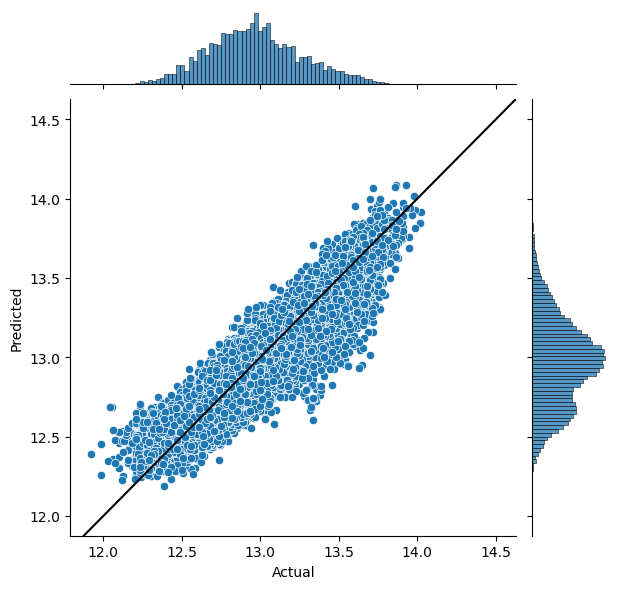

In [57]:
# lets look at the performance of ridge model on the validation data
y_pred_ridge = ridge.predict(X_test_ss)
sns.jointplot(x=y_test, y=y_pred_ridge)
plt.axline((12,12),(14.5,14.5),color='black')
plt.ylabel('Predicted')
plt.xlabel('Actual')

In [58]:
ridge.coef_

array([-0.02029575,  0.20694442,  0.01368823, -0.04313925,  0.04940084,
       -0.01368823,  0.06546681, -0.0049155 ,  0.00034136, -0.00213855,
       -0.00422391, -0.01116922, -0.04973426, -0.04346155,  0.0031621 ,
        0.01117488, -0.0045732 ,  0.00608962,  0.01368823, -0.06958778,
       -0.1391948 , -0.07865819, -0.11778536,  0.00515465,  0.00238201,
        0.01359916, -0.00228457,  0.00441034,  0.00502208,  0.02416678,
        0.00376405,  0.00054698,  0.02733763,  0.00984958])

<AxesSubplot: >

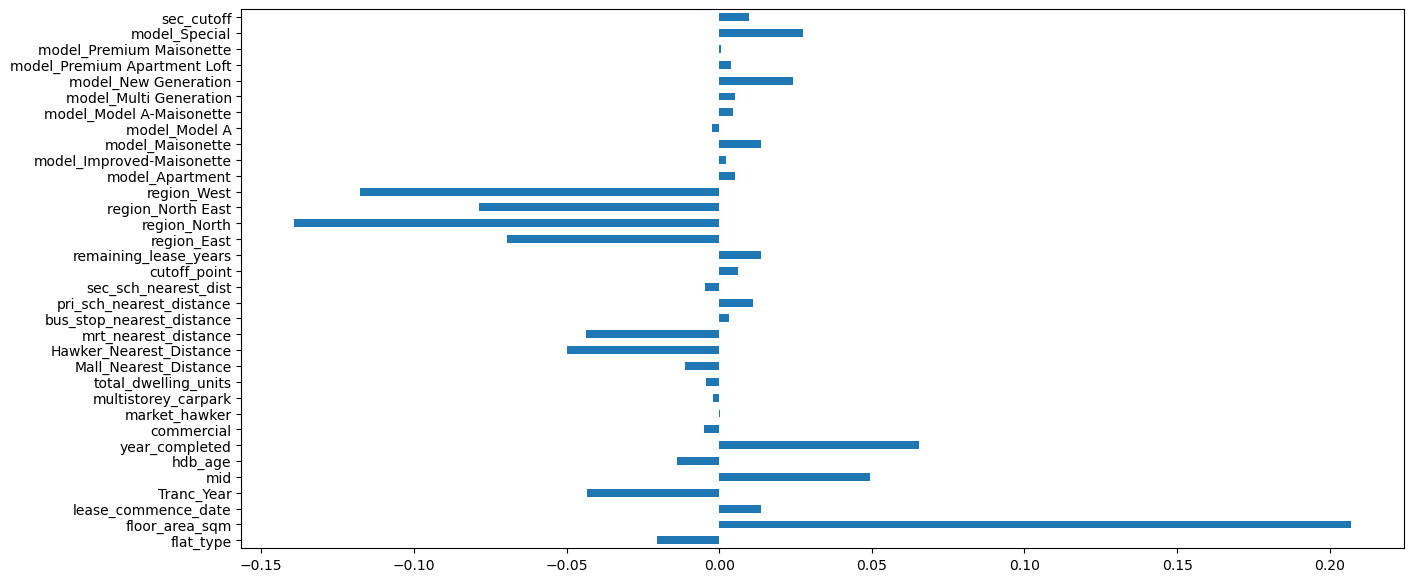

In [59]:
features = [col for col in df._get_numeric_data().columns if col != 'resale_price']
pd.Series(ridge.coef_, index=features).plot.barh(figsize=(15, 7))

**Observations**:
1. The predicted and actual values are close to the y=x line
2. It looks like some of the featues such as market_hawker, multistorey_carpark, model_Premium Maisonette are the coefficients close to zero. 
    - I will remove these features before training the model again

## Model Tuning
The aim is to decrease noise of the model by removing unnecessary features, and remove multicollinearity on features that are not so significant.

In [60]:
df.head() # get the train data

,flat_type,floor_area_sqm,lease_commence_date,resale_price,Tranc_Year,mid,hdb_age,year_completed,commercial,market_hawker,multistorey_carpark,total_dwelling_units,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,sec_sch_nearest_dist,cutoff_point,remaining_lease_years,region_East,region_North,region_North East,region_West,model_Apartment,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_Multi Generation,model_New Generation,model_Premium Apartment Loft,model_Premium Maisonette,model_Special,sec_cutoff
0,0,90.0,2006,13.429848,2016,11,15,2005,0,0,0,142,1094.090418,154.753357,330.083069,29.427395,1138.633422,1138.633422,224,83,0,0,0,0,0,0,0,1,0,0,0,0,0,0,255053.886435
1,1,130.0,1987,13.407542,2012,8,34,1987,0,0,0,112,866.941448,640.151925,903.659703,58.207761,415.607357,447.894399,232,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103911.500629
2,2,144.0,1997,13.638773,2013,14,24,1996,0,0,0,90,1459.579948,1762.082341,1334.251197,214.747860,498.849039,180.074558,188,74,0,0,0,1,1,0,0,0,0,0,0,0,0,0,33854.016862
3,0,103.0,1992,13.217674,2012,3,29,1990,1,0,0,75,950.175199,726.215262,907.453484,43.396521,389.515528,389.515528,253,69,0,0,0,0,0,0,0,1,0,0,0,0,0,0,98547.428522
4,0,83.0,1987,12.604849,2017,2,34,1987,0,0,0,48,729.771895,1540.151439,412.343032,129.422752,401.200584,312.025435,208,64,0,1,0,0,0,0,0,1,0,0,0,0,0,0,64901.290400


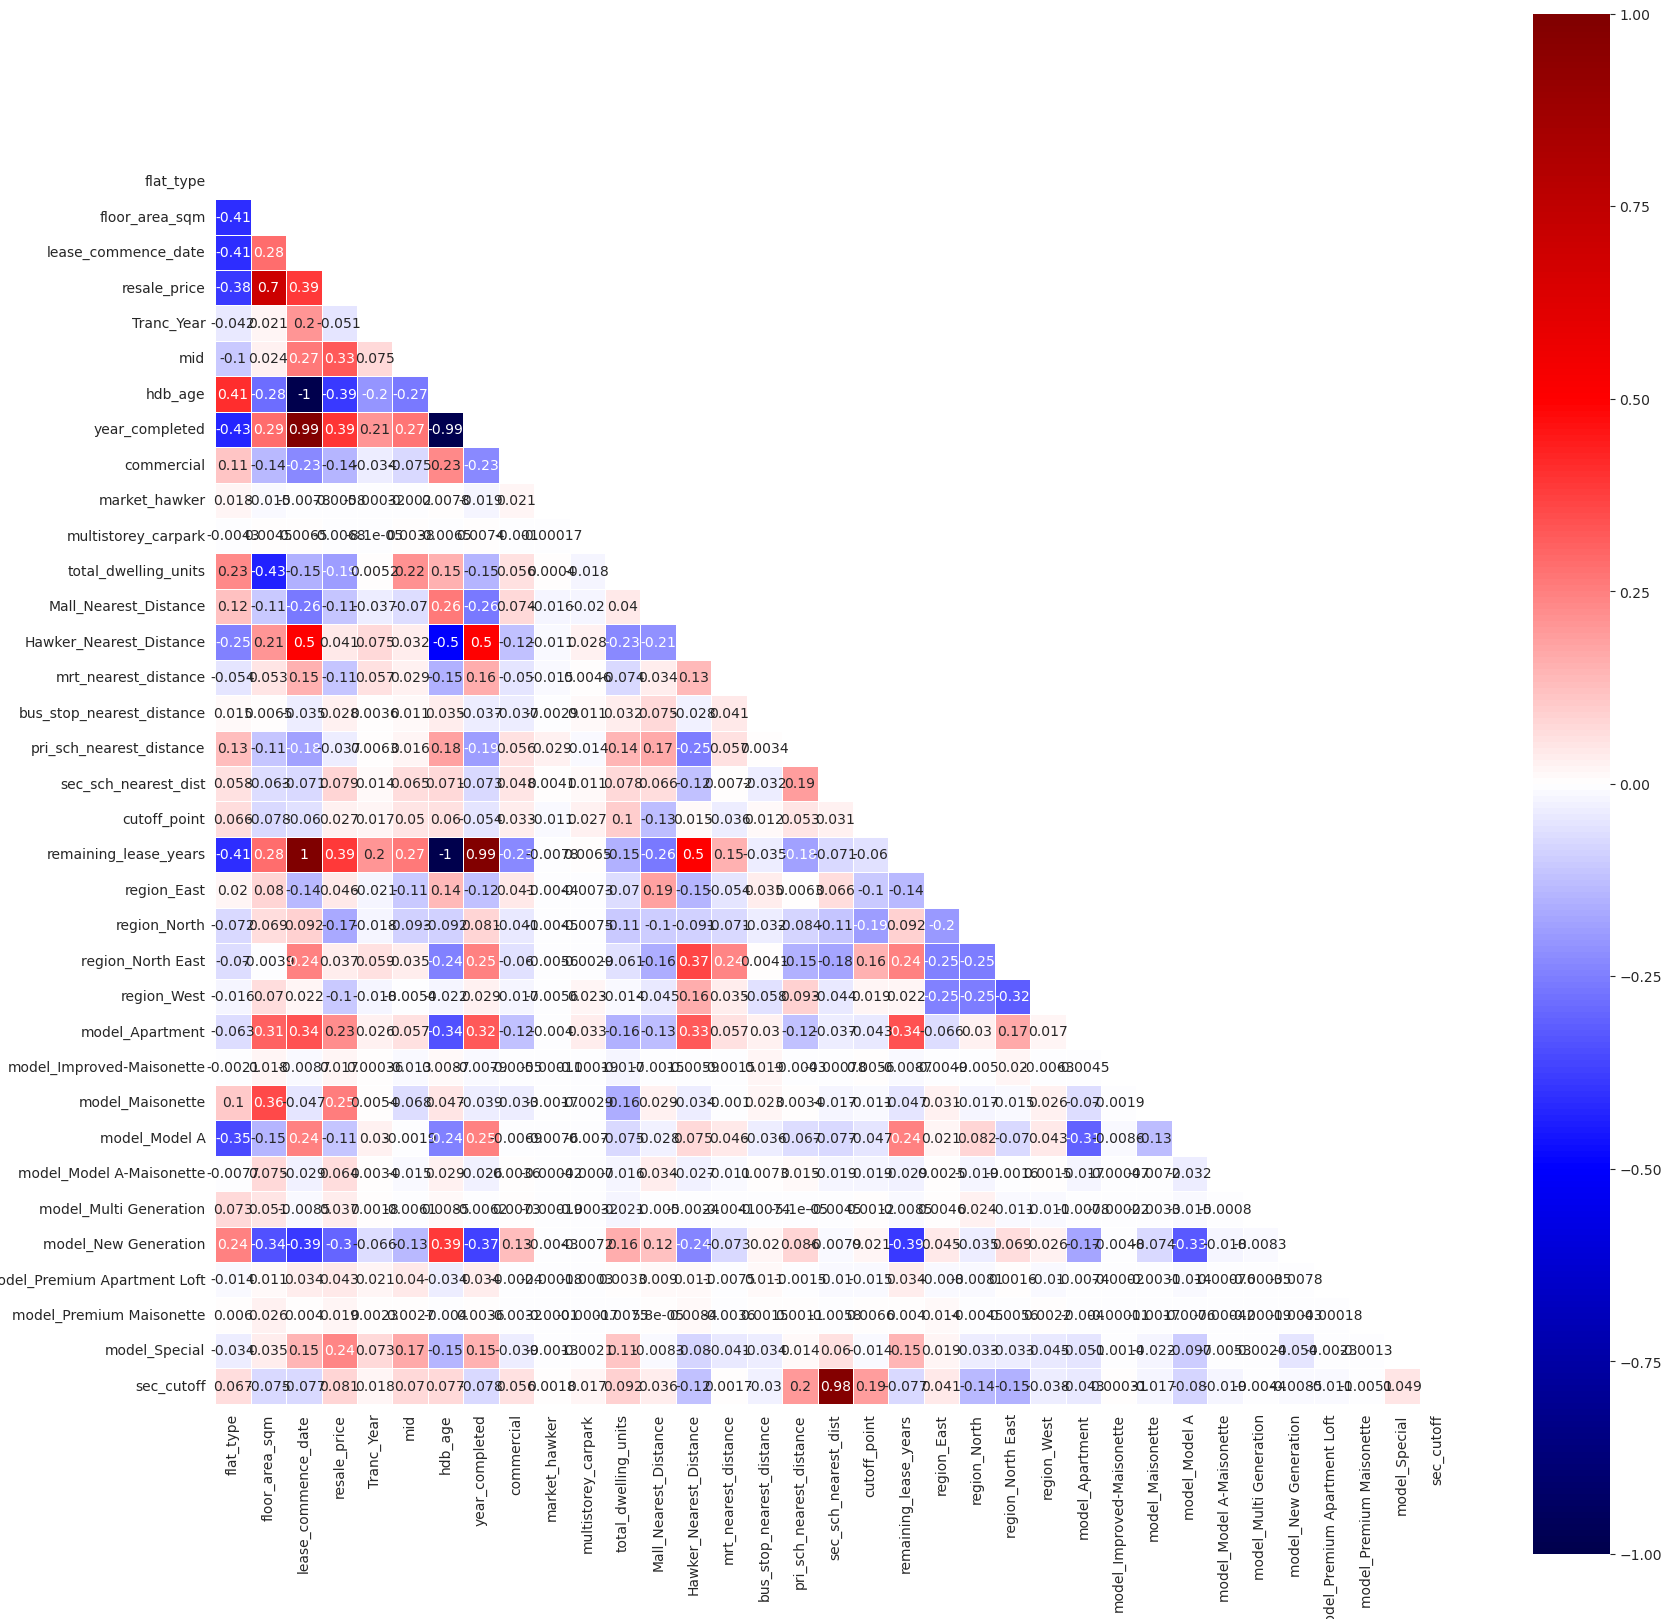

In [61]:
# check multicollinearity again
plt.figure(figsize = (20,20))

corr = df.corr()

# Set up mask to be "True" in the upper triangle. this is to reduce the number of 'squares' seen in the correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='seismic')

In [62]:
# drop the columns that are not important through feature importance 
df.drop(columns = ['market_hawker', 'multistorey_carpark', 'model_Premium Maisonette'], inplace=True)

In [63]:
df_pred.drop(columns = ['market_hawker', 'multistorey_carpark', 'model_Premium Maisonette'], inplace=True)

In [64]:

# prioritize sec_cutoff, drop sec_nearest_distance due to feature significance and multicollinearity 
# hdb_age and lease_commence_date has a perfect collinearity. Both have similar significance; but we should drop it
df.drop(columns = ['sec_sch_nearest_dist', 'hdb_age', 'lease_commence_date'], inplace=True)

In [65]:
df_pred.drop(columns = ['sec_sch_nearest_dist', 'hdb_age', 'lease_commence_date'], inplace=True)

In [66]:
# introduce interaction term for remaining_lease_years and year_completed due to multicollinearity

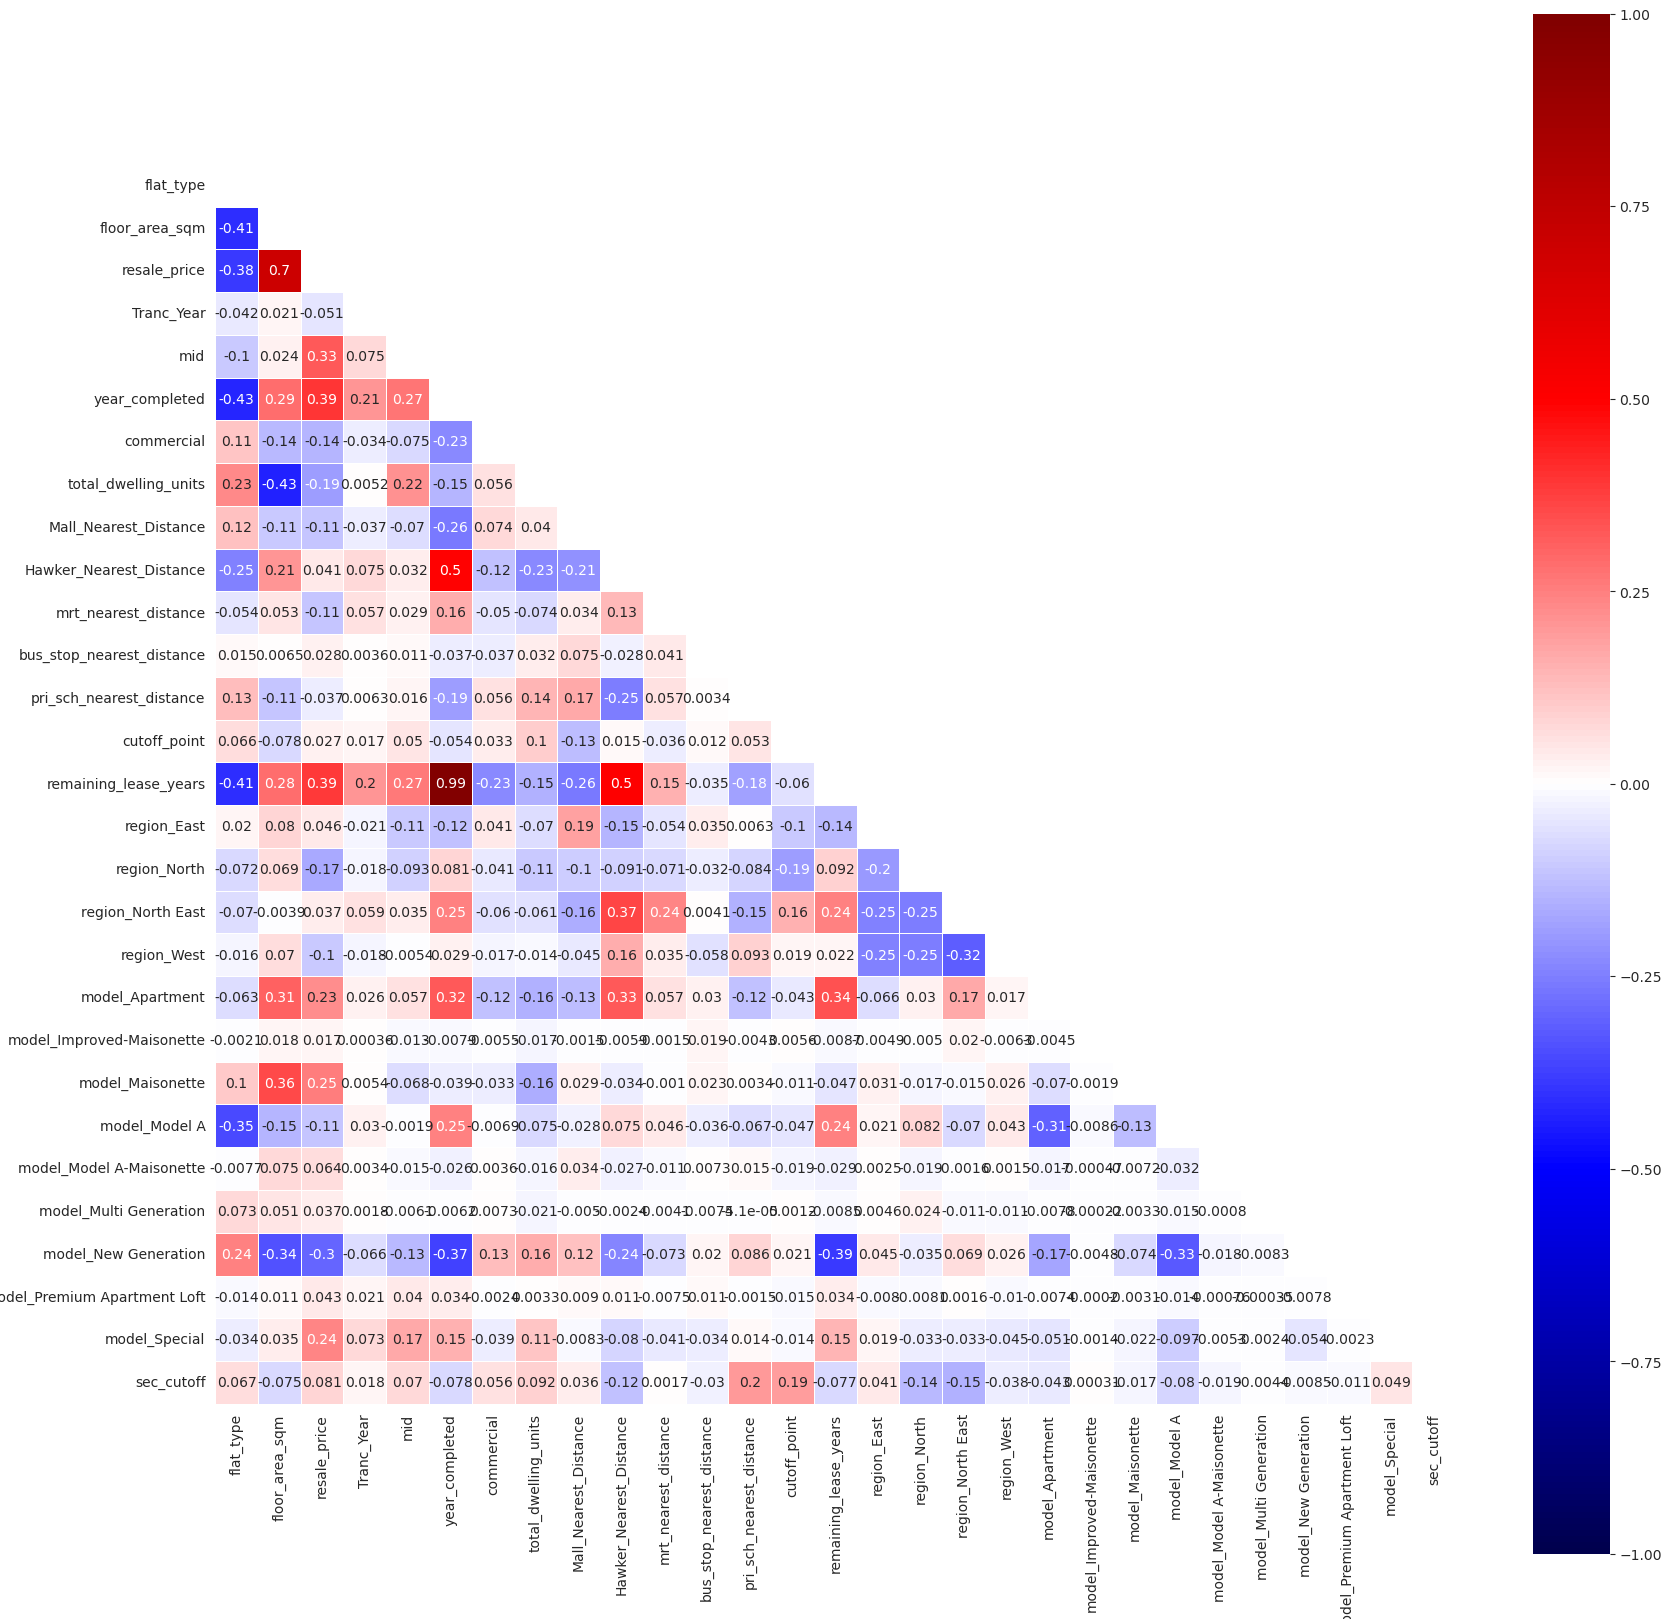

In [67]:
# check collinearity again
plt.figure(figsize = (20,20))

corr = df.corr()

# Set up mask to be "True" in the upper triangle. this is to reduce the number of 'squares' seen in the correlation heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='seismic')

**Observation**: There is no variables that has a strong multi-collinearity. Now, we can try run the model on the tuned ridge regression

## Run Production Model with refined features
In this section, we are going to use the Ridge regression model on the new set of features after tuning.

In [68]:
df.columns

Index(['flat_type', 'floor_area_sqm', 'resale_price', 'Tranc_Year', 'mid',
       'year_completed', 'commercial', 'total_dwelling_units',
       'Mall_Nearest_Distance', 'Hawker_Nearest_Distance',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'cutoff_point', 'remaining_lease_years',
       'region_East', 'region_North', 'region_North East', 'region_West',
       'model_Apartment', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special',
       'sec_cutoff'],
      dtype='object')

In [69]:
df_pred.columns

Index(['id', 'flat_type', 'floor_area_sqm', 'Tranc_Year', 'mid',
       'year_completed', 'commercial', 'total_dwelling_units',
       'Mall_Nearest_Distance', 'Hawker_Nearest_Distance',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'cutoff_point', 'remaining_lease_years',
       'region_East', 'region_North', 'region_North East', 'region_West',
       'model_Apartment', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special',
       'sec_cutoff'],
      dtype='object')

In [70]:
# set up X and y variables for the chosen product model:
X = df.drop(['resale_price'], axis = 'columns')
y = df['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # use 80/20 split, similar to the previous models
                                                    random_state = 42)

In [71]:
X.columns

Index(['flat_type', 'floor_area_sqm', 'Tranc_Year', 'mid', 'year_completed',
       'commercial', 'total_dwelling_units', 'Mall_Nearest_Distance',
       'Hawker_Nearest_Distance', 'mrt_nearest_distance',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'cutoff_point',
       'remaining_lease_years', 'region_East', 'region_North',
       'region_North East', 'region_West', 'model_Apartment',
       'model_Improved-Maisonette', 'model_Maisonette', 'model_Model A',
       'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special',
       'sec_cutoff'],
      dtype='object')

In [72]:
# do standard scaling on the new set of features

ss = StandardScaler()

# we will use fit_transform on X_train
# use transform on X_test
X_train_ss2 = ss.fit_transform(X_train)
X_test_ss2 = ss.transform(X_test)

In [73]:
# initialize the second ridge regression
ridge_2 = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores_2 = cross_val_score(ridge_2, X_train_ss2, y_train, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[0.83401182 0.83799514 0.84010576 0.83991973 0.83781508 0.83833294
 0.84313046 0.84204077 0.83937544 0.83949582]
0.8392222963385538


In [74]:
ridge_2.fit(X_train_ss2, y_train)

Ridge(alpha=6.747544053110695)

## Model Evaluation: Production model (on train data)

In [75]:
# lets look at the performance of the ridge regression model

# run predictions on validation set
y_val_ridge_2 = ridge_2.predict(X_test_ss2)

In [76]:
# evaluating the ridge_2 regression
rmse_ridge2 = mean_squared_error(y_test, y_val_ridge_2)
diff_r2_ridge2 = (ridge_2.score(X_test_ss2, y_test)) - (np.mean(ridge_scores_2))
r2_ridge2 = r2_score(y_test, y_val_ridge_2)
print("RMSE for refined Ridge regression:", np.sqrt(rmse_ridge2))
print("R-Squared for refined Ridge regression:", r2_ridge2)
print ("Difference in R-Squared for tuned ridge regression:", np.abs(diff_r2_ridge2))

print("----------------------")

# printing the tuned ridge regression 
mse_optimized_ridge = mean_squared_error(y_test, y_pred_ridge)
diff_r2_optimized_ridge = (ridge.score(X_test_ss, y_test)) - (np.mean(ridge_scores))
r2_optimized_ridge = r2_score(y_test, y_pred_base_ridge)

print("RMSE for optimized ridge regression:", np.sqrt(mse_optimized_ridge))
print("R-Squared on test data with optimized ridge regression:", r2_optimized_ridge)
print ("Difference in R-Squared for optimized ridge regression:", np.abs(diff_r2_optimized_ridge))


RMSE for refined Ridge regression: 0.12129841659260203
R-Squared for refined Ridge regression: 0.8388226478872196
Difference in R-Squared for tuned ridge regression: 0.00035484407761754433
----------------------
RMSE for optimized ridge regression: 0.1213097260280043
R-Squared on test data with optimized ridge regression: 0.8387919689413628
Difference in R-Squared for optimized ridge regression: 0.0004297050650989842


**Observation**: 
1. The second optimized ridge model improved r2 score on the validate data slightly by 0.0000001 as compared to the first optimized ridge model 
   - This means there's a higher amount of train data being able to be explained by the model
2. Also, the RMSE for the refined Ridge model is slighly lower than the first optimized ridge model
   - this means the model has a smaller error
3. The difference in R2 score is also smaller
   - this might mean that the model is less biased

Text(0.5, 1.0, 'Predicted vs Actual for Tuned Ridge Regression')

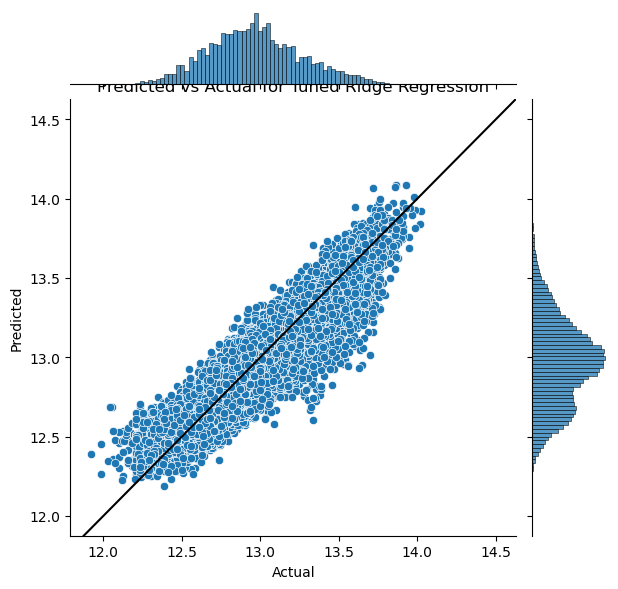

In [77]:
# plot the results from the prediction on validation set against true values in the validation set
sns.jointplot(x=y_test, y=y_val_ridge_2)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((12,12),(14.5,14.5),color='black')
plt.title('Predicted vs Actual for Tuned Ridge Regression')

**Observation**: 
Actual vs Prediction values seems to hover around a y=x line.
1. This looks quite promising, as it means prediction values are quite close to the actual values. 
2. However, we need to see the distribution of errors to make sure the model do not have any features which has collinearity.

In [78]:
# find residuals = actual - prediction
residuals = y_test - y_val_ridge_2

Text(0.5, 1.0, 'Residuals of Tuned Ridge Regression')

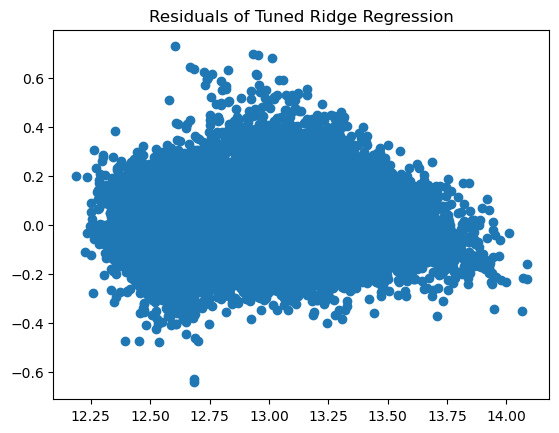

In [79]:
plt.scatter(y_val_ridge_2, residuals)
plt.title('Residuals of Tuned Ridge Regression')

**Observations**: The residuals do not fan out. This means it meets the homoscedastic error structure. This is desirable because it suggests that the variance of the errors is consistent and that the model's assumptions of equal variances across the range of the predictor variable are satisfied.

We can now fit this model to the test data

## Model Evaluation: Base Model

In [80]:
# base model predictions
mean_y = np.mean(df['resale_price'])

In [120]:
print (np.exp(mean_y))

428652.76762066945


In [81]:
# get the rmse of the residuals

pred_base = np.array([mean_y for i in range(len(df['resale_price']))])
residuals_base_model = y - pred_base # use the whole df
squared_residuals = residuals_base_model ** 2
mean_squared_residuals = np.mean(squared_residuals)
rmse_base_model = np.sqrt(mean_squared_residuals)

print (f'RMSE for base model is: {rmse_base_model}')

RMSE for base model is: 0.30215097516294764


In [82]:
# calculate the residuals of the base model
residuals_base_model = y_test - np.mean(df['resale_price'])

Text(0.5, 1.0, 'Residuals of Base model')

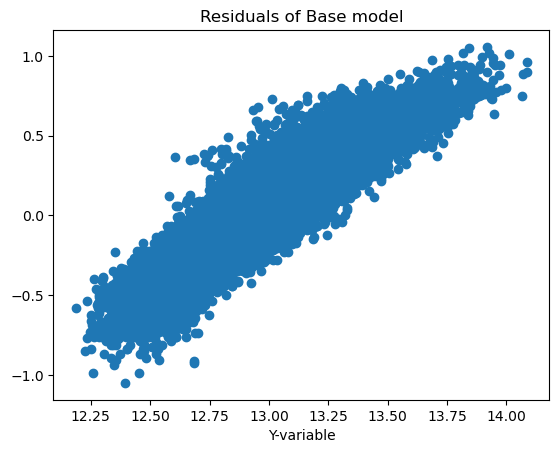

In [84]:
plt.scatter(y_val_ridge_2, residuals_base_model)
plt.xlabel('Y-variable')
plt.title('Residuals of Base model')

**Observations**: There is significant improvements with the chosen model (Ridge regression) against the base model 
1. Residuals: 
   - Base model: The residuals seems to have a linear relationship, which suggests heteroscedasticity
   - Chosen model: The residuals appear random and do not fan out

2. RMSE score :
   - Base model: 0.30215097516294764 
   - Chosen model: 0.12123973707935588, which is lower than the base model

## Production Model (for Kaggle Submission)
With the evaluation above, I will fit the improved Ridge regression as a prodiction mode into the test dataset

In [93]:
df_pred.columns

Index(['id', 'flat_type', 'floor_area_sqm', 'Tranc_Year', 'mid',
       'year_completed', 'commercial', 'total_dwelling_units',
       'Mall_Nearest_Distance', 'Hawker_Nearest_Distance',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'cutoff_point', 'remaining_lease_years',
       'region_East', 'region_North', 'region_North East', 'region_West',
       'model_Apartment', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special',
       'sec_cutoff', 'model_Type S1', 'model_Type S2'],
      dtype='object')

In [100]:
# define the list of features without id
features = ['flat_type', 'floor_area_sqm', 'Tranc_Year', 'mid', 'year_completed',
       'commercial', 'total_dwelling_units', 'Mall_Nearest_Distance',
       'Hawker_Nearest_Distance', 'mrt_nearest_distance',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'cutoff_point',
       'remaining_lease_years', 'region_East', 'region_North',
       'region_North East', 'region_West', 'model_Apartment',
       'model_Improved-Maisonette', 'model_Maisonette', 'model_Model A',
       'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special','sec_cutoff']

In [101]:
# set X variables
X_prod = df_pred[features]

In [102]:
X_prod.shape

(16737, 28)

In [103]:
X_prod = ss.transform(X_prod)

In [104]:
df_pred.head()

,id,flat_type,floor_area_sqm,Tranc_Year,mid,year_completed,commercial,total_dwelling_units,Mall_Nearest_Distance,Hawker_Nearest_Distance,mrt_nearest_distance,bus_stop_nearest_distance,pri_sch_nearest_distance,cutoff_point,remaining_lease_years,region_East,region_North,region_North East,region_West,model_Apartment,model_Improved-Maisonette,model_Maisonette,model_Model A,model_Model A-Maisonette,model_Multi Generation,model_New Generation,model_Premium Apartment Loft,model_Special,sec_cutoff,model_Type S1,model_Type S2
0,114982,0,84.0,2012,8,1986,1,132,877.431572,687.576779,686.660434,75.683952,426.467910,218,64,0,1,0,0,0,0,0,1,0,0,0,0,0,34078.273019,0,0
1,95653,1,112.0,2019,5,2002,0,53,534.037705,2122.346226,169.478175,88.993058,439.756851,199,85,0,0,0,1,1,0,0,0,0,0,0,0,0,147134.965932,0,0
2,40303,3,68.0,2013,8,1979,0,218,817.050453,152.287621,694.220448,86.303575,355.882207,245,57,0,0,1,0,0,0,0,0,0,0,1,0,0,74742.441795,0,0
3,109506,0,97.0,2017,2,1976,0,104,1272.737194,501.892158,1117.203587,108.459039,929.744711,188,56,0,1,0,0,0,0,0,0,0,0,1,0,0,81489.463089,0,0
4,100149,0,103.0,2016,17,1985,0,144,1070.963675,437.593564,987.976010,113.645431,309.926934,223,62,0,0,0,1,0,0,0,1,0,0,0,0,0,48456.865525,0,0


In [105]:
X_train_ss.shape

(120507, 34)

In [106]:
X_prod.shape

(16737, 28)

In [107]:
from sklearn.compose import TransformedTargetRegressor

In [108]:
# this is to fit into train data
ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log, inverse_func=np.exp
).fit(X_train_ss2, y_train)
y_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test_ss2)

print (np.exp(y_ridge_with_trans_target))

[430903.03451203 569808.77985895 893801.70986598 ... 634210.03513124
 550938.47356002 372127.09178941]


In [109]:
# fit into test data
y_prod_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_prod)

print (np.exp(y_prod_ridge_with_trans_target))

[334356.62027136 485014.00075547 346726.67335395 ... 395695.57722185
 426892.49244565 413558.41445783]


In [110]:
df_pred['Predicted'] = y_prod_ridge_with_trans_target

In [111]:
kaggle_df = df_pred[['id','Predicted']]

In [112]:
kaggle_df.to_csv('./datasets/submission_hdb.csv',index=False)

In [113]:
kaggle_df.head()

,id,Predicted
0,114982,12.719963
1,95653,13.091933
2,40303,12.756292
3,109506,12.675647
4,100149,12.964886


In [114]:
df_pred.columns

Index(['id', 'flat_type', 'floor_area_sqm', 'Tranc_Year', 'mid',
       'year_completed', 'commercial', 'total_dwelling_units',
       'Mall_Nearest_Distance', 'Hawker_Nearest_Distance',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'cutoff_point', 'remaining_lease_years',
       'region_East', 'region_North', 'region_North East', 'region_West',
       'model_Apartment', 'model_Improved-Maisonette', 'model_Maisonette',
       'model_Model A', 'model_Model A-Maisonette', 'model_Multi Generation',
       'model_New Generation', 'model_Premium Apartment Loft', 'model_Special',
       'sec_cutoff', 'model_Type S1', 'model_Type S2', 'Predicted'],
      dtype='object')

In [115]:
ridge_2.coef_

array([-0.02024665,  0.2070172 , -0.04313636,  0.04937432,  0.06529922,
       -0.00489687, -0.00418332, -0.01119001, -0.04977671, -0.04348122,
        0.00313308,  0.01125223,  0.00676716,  0.04130406, -0.06962985,
       -0.13921453, -0.07866488, -0.11785477,  0.00505763,  0.00238313,
        0.01358402, -0.00227719,  0.00441399,  0.00501423,  0.02416215,
        0.00376709,  0.02728253,  0.00516707])

In [116]:
df_pred_coeff = df_pred.drop(columns=['id'])

In [117]:
#last check on the features and respective coefficients
ridge_2_coeffs = pd.DataFrame({
        'Feature' : features,
    'Coefficient' : ridge_2.coef_,
    'Absolute Coefficient' : np.abs(ridge_2.coef_)
})
# Sort the values by descending order
ridge_2_sorted_coeffs = ridge_2_coeffs.sort_values('Absolute Coefficient', ascending=False)

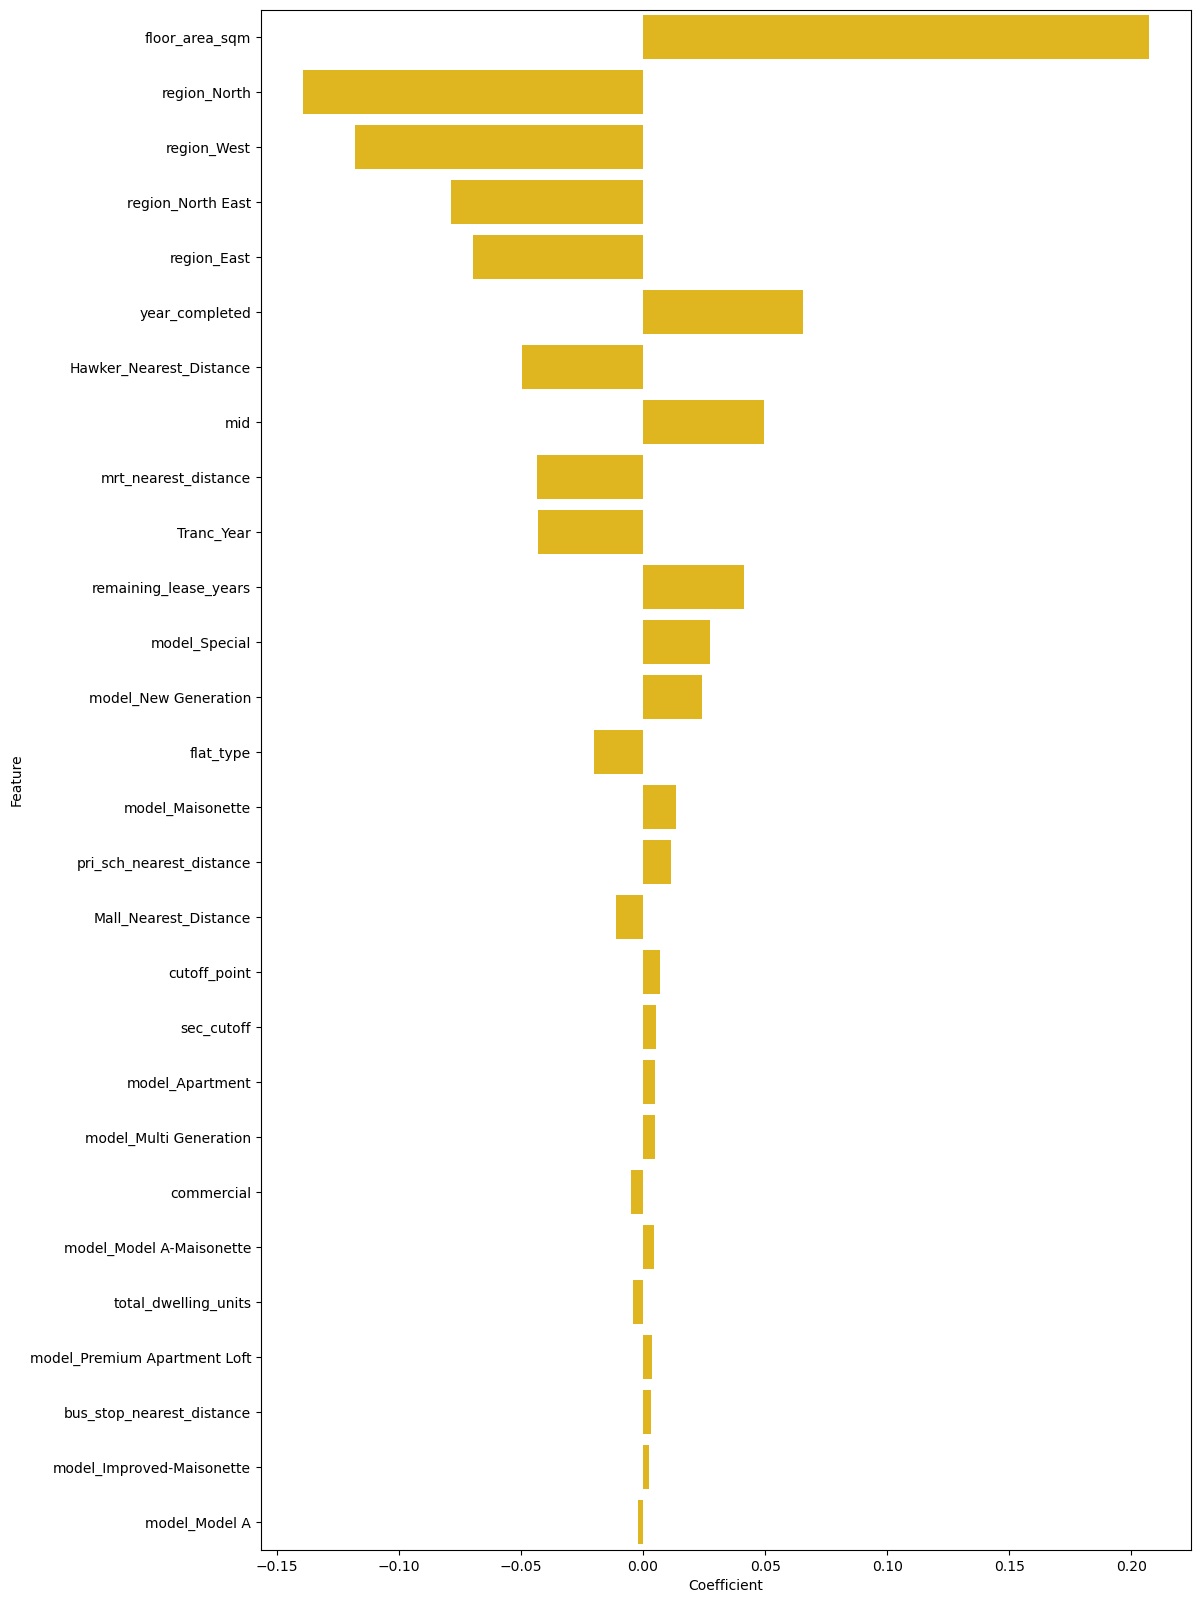

In [118]:
# Plot the coefficients in descending order
fix, ax = plt.subplots(figsize=(12,20))
sns.barplot(data=ridge_2_sorted_coeffs, x='Coefficient', y='Feature', orient='h', color='#FFC800');

**Observation**: 
1. Besides size, the other factors that affects HDB prices are remaining lease years, nearby amenities (such as MRT and Hawker centers), storey of the HDB, and town. It is also interesting that not all town has the same intensity in terms of effect on the resale prices.
2. Firstly, well-known factors such as size, lease remaining, height of the HDB are features that are well-known, and is proven to have significant contribution towards a desirable HDB. So our recommendations to buyers is to find a house that fits their budget and comfort level
3. Distance to amenities such as Hawker and MRT plays a role on the HDB resale prices too. However, most HDBs are comparatively close to such amenities; thanks to the master plans of LTA and URA. In fact, LTA has promise that 80% of the households would be within a 10-min walk from a train station by 2030.
4. Most importantly, we found that a town do not play such a significant role as we thought - debunking the usual thought on 'location x3'. 
    - This is because the definition of a 'good' town is relative and changes over time
    - For example, the Woodleigh area used to be a cemetery and was avoided. In those days, apartments around that area was cheap. Now, it becomes a place with high demand after it has been developed.
    - We have also heard about the move of ACS to Tengah. This has caused that area to be hotter, despite being so far away from town.

## Kaggle Submission Results

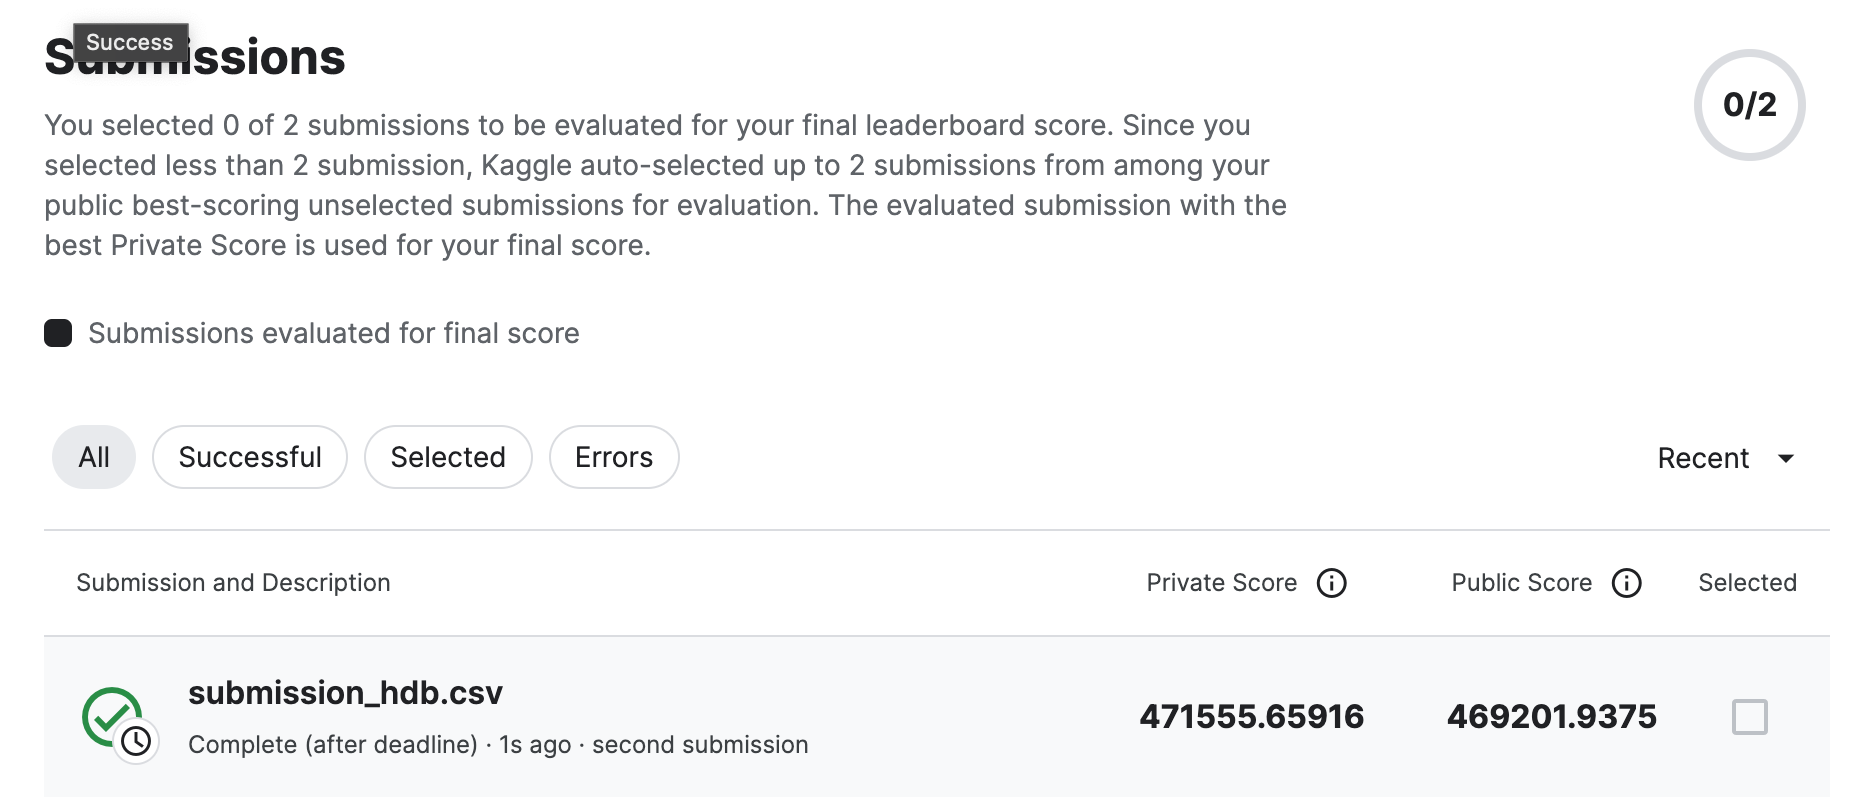

# Future enhancements and recommendation
The model is not perfect, and can be further trained. Here are a few ideas:

**Data Preprocessing**
1. Group by number of rooms 
    - A 4R HDB flat has the most demand. 
    - In fact, most of the outliers lies with the 4R, 5R, and Executive HDB flats (https://www.propertyguru.com.sg/property-guides/million-dollar-4-room-flats-72832)
    - By controlling the number of rooms, we can train better models with specific features for a 4R-HDB flats

2. Group by regions
    - At first glance, AMK seems to be an undervalued town
    - There is a possibility that the area has older flats; hdb_age is one of the more important features in predicting resale_prices
    - We can do an EDA to find out more
    
3. Group by amenities 
    - currently, amenities such as mrt, school, bus stop, mall and hawker center are shown in meters
    - realistically, amenities within a certain circumference (not by absolute distance) would be considered by a potential buyer
    - therefore, it would be great to group them together for a better analysis 

**Methodology**: 
1. I can further prune the model into lesser features, dropping more features that do not matter
   - for example, I can further drop the features, starting from model_Type S1
2. r2 scores of the models are consistently hovering at 0.838. One of the reasons is due to the grouping of town into regions and that might not be an effective predictor. 
   - For example, Geylang is considered 'central', yet the median resale price is one of the bottom 5.

**More data on:** To improve the model, I think it will be worthwhile to have the following:
1. The interior design of the HDB: well-maintained and better interior design HDB can fetch a much higher price than those without a good interior design
2. We also need data to capture the macro trends, such as changes in government policies and the bank interest rate.
3. Besides, the model should capture seasonality of demand. 
    - for example, [areas with flats that hit MOP](https://www.99.co/singapore/insider/full-list-hdb-bto-projects-mop-2023/) may have a surge in demand, and may drive the resale prices up.